<h1>Simple Parser & TF-IDF</h1>
USES PYTHON 3.x

First we specify all the directories and filenames that will be used in our code. Keeping them up here makes them easier to find and change later.

In [2]:
DATA_PATH = "texts/" # The directory to look in for all the text files to be analyzed.

#The names (and locations) of the csv files that will be created:
WORD_FREQUENCY_CSV_FILENAME = "Frequencies.csv"
INVERSE_DOCUMENT_FREQUENCY_CSV_FILENAME = "InverseDocumentFrequencies.csv"
TF_IDF_CSV_FILENAME = "tfidf.csv"

<h1>Find All the Files to be Analyzed</h1>
This next section of code is some very simple code that finds all the text files, and then keeps track of where they are located, so that future functions can find them all when they need to do processing on them. This is cheaper than trying to keep the contents of all the text files in memory. This is a good starting point for any sort of text analysis.

In [3]:
import os

textdirs = os.listdir(DATA_PATH) # returns list
texts = []

#Loop over all of the files in the provided directory
for file in textdirs:
    
    #Ensure that only text files are included:
    if file.endswith(".txt"):
        text_dir = os.path.join(DATA_PATH, file)
        texts.append(text_dir)        

Here's just a simple demonstration that the array is indeed filled with the paths to all the .txt files in the text directory.

In [3]:
print(texts)

['texts/A-Cather-Antonia-1918-F.txt', 'texts/A-Chesnutt-Marrow-1901-M.txt', 'texts/A-Crane-Maggie-1893-M.txt', 'texts/A-Davis-Life_Iron_mills-1861-F.txt', 'texts/A-Dreiser-Sister_Carrie-1900-M.txt', 'texts/A-Hawthorne-Scarlet_Letter-1850-M.txt', 'texts/A-Howells-Silas_Lapham-1885-M.txt', 'texts/A-James-Golden_Bowl-1904-M.txt', 'texts/A-Jewett-Pointed_Firs-1896-F.txt', 'texts/A-London-Call_Wild-1903-M.txt', 'texts/A-Melville-Moby_Dick-1851-M.txt', 'texts/A-Norris-Pit-1903-M.txt', 'texts/A-Twain-Huck_Finn-1885-M.txt', 'texts/A-Wharton-Age_Innocence-1920-F.txt', 'texts/B-Bronte-Jane_Eyre-1847-F.txt', 'texts/B-Bronte-Wuthering_Heights-1847-F.txt', 'texts/B-Collins-Woman_White-1860-M.txt', 'texts/B-Conrad-Heart_Darkness-1902-M.txt', 'texts/B-Dickens-Bleak_House-1853-M.txt', 'texts/B-Disraeli-Sybil-1845-M.txt', 'texts/B-Eliot-Middlemarch-1869-F.txt', 'texts/B-Gaskell-Cranford-1853-F.txt', 'texts/B-Gissing-Grub_Street-1893-M.txt', 'texts/B-Hardy-Tess-1891-M.txt', 'texts/B-Stevenson-Treasure_I

<h1>Term Frequency</h1>
The code below generates a wordcounts.csv file containing the word counts for each of the above files.

In [4]:
# THIS IS A PROBLEM "abandoned--my" is seen as the word "abandonedmy" Will need to figure out a suitable regular expression.


import csv
import string
#import re
import pandas as pd
#from collections import Counter

num_lines = 0
num_words = 0
num_chars = 0

counts = {}
docs = {}

with open('wordfrequencies.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    writer.writerow(['filename', 'Line Count', 'Word Count', 'Character Count'])
    for text in texts:
        with open(text, 'r', encoding="utf-8") as f:
            for line in f:
                line = line.translate(str.maketrans('','',string.punctuation)).lower()
                words = line.split()
                #counts = counts + Counter(words)
                for word in words:

                    try:
                        counts[word]
                    except KeyError:
                        counts[word] = 1
                    else:
                        counts[word] = counts[word] + 1
                num_lines += 1
                num_words += len(words)
                num_chars += len(line)
        
        #print(words)
        #print(counts)
        relativefreqs = {}
        for word, rawCount in counts.items():
            
            # gather only words with alphabetical characters, discard numbers
            if word.isalpha():
                relativefreqs[word] = rawCount
            
        # add this document's relative freqs to our dictionary
        docs[os.path.basename(text)] = relativefreqs
        #writer.writerow([text, num_lines, num_words, num_chars])

#output everything to a .csv file, using pandas as a go between.
df = pd.DataFrame(docs)

df.to_csv(WORD_FREQUENCY_CSV_FILENAME) # write out to CSV
print("Done.")    

Done.


<h1>Inverse Document Frequency</h1>

Inverse document frequency is calculted as follows:
IDF-FOR-TERM-X = log( TOTAL_DOCUMENTS / (TOTAL_DOCUMENTS_CONTAINING_X) )

Sometimes (TOTAL_DOCUMENTS_CONTAINING_X) has a one added to it to prevent division by zero, but in this case, because all the terms are drawn from the documents themselves, that should never happen.

In [5]:
import csv
import math

idf = {}

with open(WORD_FREQUENCY_CSV_FILENAME, newline='') as csvfile:
    wordsreader = csv.reader(csvfile, delimiter=',', quotechar='"')
    
    #skip header information
    total_documents = len(next(wordsreader, None)) - 1
    for row in wordsreader:
        docsContainingWord = -1
        for entry in row:
            if not entry is '':
                docsContainingWord += 1
        idf[row[0]] = math.log10( total_documents / docsContainingWord)
        
df = pd.DataFrame(idf, index=['Inverse Document Frequency'])
df2 = df.transpose()
df2.to_csv(INVERSE_DOCUMENT_FREQUENCY_CSV_FILENAME)
print("Done.")

Done.


<h1>TF-IDF</h1>
This is just the term frequency multiplied by the inverse document frequency:

In [6]:
import csv

file1reader = csv.reader(open(WORD_FREQUENCY_CSV_FILENAME), delimiter=",")
file2reader = csv.reader(open(INVERSE_DOCUMENT_FREQUENCY_CSV_FILENAME), delimiter=",")

def is_number(s):
    try:
        float(s)
        return True
    except ValueError:
        return False

#skip headers
header1 = next(file1reader) #header
header2 = next(file2reader) #header
with open(TF_IDF_CSV_FILENAME, 'w', newline='') as csvfile:
    writer = csv.writer(csvfile, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    writer.writerow(header1)
    for row1, row2 in zip(file1reader, file2reader):
        rowOut = []
        for entry in row1:
            if (is_number(entry)):
                entry = float(entry) * float(row2[1])
            rowOut.append(entry)
        writer.writerow(rowOut)
    
print("Done.")

Done.


<h1>Tables and Graphs</h1>
Now that we have our TF-IDF data stored in a csv, we can load it into Pandas and get some visualizations.

First, just a simple table showing what our csv looks like.

In [7]:
df = pd.read_csv(TF_IDF_CSV_FILENAME, index_col=0) # read in the CSV
df.rename(columns={'Unnamed: 0': 'Text'}, inplace=True) # add a label to the first column
df = df.fillna(0) # replace NaNs with zeroes.
df.head(10)

,A-Cather-Antonia-1918-F.txt,A-Chesnutt-Marrow-1901-M.txt,A-Crane-Maggie-1893-M.txt,A-Davis-Life_Iron_mills-1861-F.txt,A-Dreiser-Sister_Carrie-1900-M.txt,A-Hawthorne-Scarlet_Letter-1850-M.txt,A-Howells-Silas_Lapham-1885-M.txt,A-James-Golden_Bowl-1904-M.txt,A-Jewett-Pointed_Firs-1896-F.txt,A-London-Call_Wild-1903-M.txt,...,B-Dickens-Bleak_House-1853-M.txt,B-Disraeli-Sybil-1845-M.txt,B-Eliot-Middlemarch-1869-F.txt,B-Gaskell-Cranford-1853-F.txt,B-Gissing-Grub_Street-1893-M.txt,B-Hardy-Tess-1891-M.txt,B-Stevenson-Treasure_Island-1883-M.txt,B-Thackeray-Vanity_Fair-1848-M.txt,B-Trollope-Live_Now-1875-M.txt,B-Wells-Time_Machine-1895-M.txt
a,0,0,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
aa,0,0,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.216709,0.216709,0.216709,0.216709,0.433418,0.433418,0.433418,0.433418,0.433418,0.433418
aaah,0,0,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.168404,...,0.168404,0.168404,0.168404,0.168404,0.168404,0.168404,0.168404,0.168404,0.168404,0.168404
aamen,0,0,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.486076,0.486076,0.486076,0.486076,0.486076,0.486076,0.486076,0.486076,0.486076,0.486076
aanot,0,0,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.492916,0.492916,0.492916,0.492916,0.492916,0.492916,0.492916,0.492916,0.492916
aaron,0,0,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.492916,0.492916,0.492916,0.492916,0.492916,0.492916,0.492916,0.492916,0.492916
ab,0,0,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.486076,0.486076,0.486076,0.486076,0.486076,0.486076,0.486076,0.486076,0.486076,0.486076
aback,0,0,0,0,0.066947,0.066947,0.066947,0.066947,0.066947,0.133894,...,0.669468,0.669468,0.669468,0.736415,0.736415,0.736415,0.937255,1.004202,1.004202,1.004202
abaddon,0,0,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.602060,0.602060,0.602060,0.602060,0.602060,0.602060,0.602060
abaft,0,0,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.383771,0.383771,0.383771,0.383771,0.383771,0.383771,0.383771,0.383771,0.383771,0.383771


Let's transpose the table, swapping the columns and rows:

In [8]:
df2 = df.transpose()
df2.head(20)

,a,aa,aaah,aamen,aanot,aaron,ab,aback,abaddon,abaft,...,zoodle,zoological,zoology,zornes,zoroaster,zrilla,zu,zuleikah,zum,zwiebacks
A-Cather-Antonia-1918-F.txt,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0,0,0,0
A-Chesnutt-Marrow-1901-M.txt,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0,0,0,0
A-Crane-Maggie-1893-M.txt,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0,0,0,0
A-Davis-Life_Iron_mills-1861-F.txt,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0,0,0,0
A-Dreiser-Sister_Carrie-1900-M.txt,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.066947,0,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0,0,0,0
A-Hawthorne-Scarlet_Letter-1850-M.txt,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.066947,0,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0,0,0,0
A-Howells-Silas_Lapham-1885-M.txt,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.066947,0,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.628412,0,0,0,0
A-James-Golden_Bowl-1904-M.txt,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.066947,0,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.628412,0,0,0,0
A-Jewett-Pointed_Firs-1896-F.txt,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.066947,0,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.628412,0,0,0,0
A-London-Call_Wild-1903-M.txt,0,0.000000,0.168404,0.000000,0.000000,0.000000,0.000000,0.133894,0,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.628412,0,0,0,0


Now we can make graphs based on specific words.

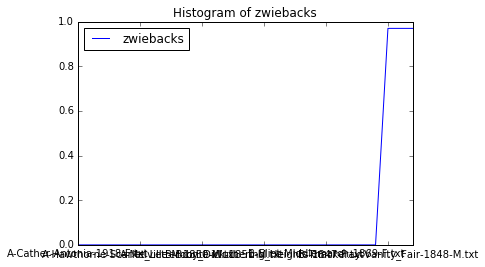

In [9]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

word2Plot = "zwiebacks" # change this to see different words

plt.figure(figsize=(16, 16))
# plt.rcParams.update({'font.size': 12})
df2[[word2Plot]].plot()
plt.title('Histogram of ' + word2Plot)
plt.show()